In [1]:
# parameters
start_year = 2009
start_month = 1
start_day = 1

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches
import pandas as pd
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point

In [3]:
INALT_mask=xr.open_dataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
particle_ds = xr.open_dataset(f'/gxfs_work/geomar/smomw523/master-thesis/output_data/INALT20.L46-KFS119/Track10-Column_test_1500_{start_year:04d}{start_month:02d}{start_day:02d}_RT-42_N-100000_seed-12345.nc')
SIGMA=xr.open_dataset('/gxfs_work/geomar/smomw523/master-thesis/data/config/ROMS/sigma2depth_parent.nc')
ROMS_ds = xr.open_dataset(f'/gxfs_work/geomar/smomw523/master-thesis/output_data/ROMS/Track10-Column_test_1500_{start_year:04d}{start_month:02d}{start_day:02d}_RT-42_N-100000_seed-12345.nc')
SIGMA_child=xr.open_dataset('/gxfs_work/geomar/smomw523/master-thesis/data/config/ROMS/sigma2depth_child.nc')
ROMSchild_ds = xr.open_dataset(f'/gxfs_work/geomar/smomw523/master-thesis/output_data/ROMS_child/Track10-Column_test_1500_{start_year:04d}{start_month:02d}{start_day:02d}_RT-42_N-100000_seed-12345.nc')
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 100000, obs: 44)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
    topography  (traj, obs) float32 ...
    depthdiff   (traj, obs) float32 ...
    distance    (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

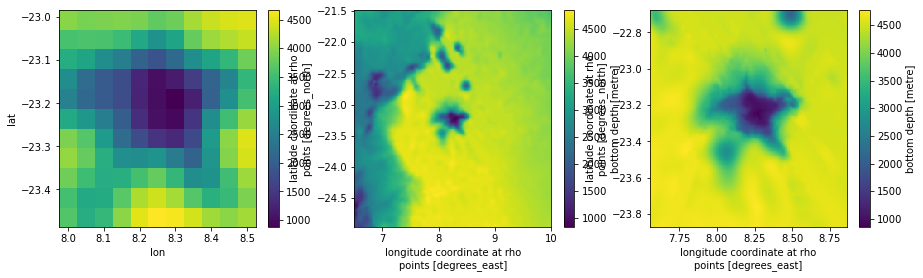

In [4]:
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0),
                                       "lat": INALT_mask.gphit.isel(t=0,x=0),
                                      })
topo_INALT = topo_INALT.swap_dims({'x': 'lon', 'y': 'lat'})

plt.figure(figsize=(15,4))
plt.subplot(1, 3,1)
topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).plot()
plt.subplot(1, 3,2)
SIGMA.h.plot()
plt.subplot(1, 3,3)
SIGMA_child.h.plot();

In [5]:
MLD = pd.read_csv('/gxfs_work/geomar/smomw523/master-thesis/output_data/retention/MLD2009_s001_EOS80-full.csv',index_col=0)

In [6]:
# Mixed layer depth at release day
MLD_INALT_1d = MLD.INALT[f'{start_year:04d}-{start_month:02d}-{start_day:02d}']
MLD_ROMS_1d = MLD.ROMS[f'{start_year:04d}-{start_month:02d}-{start_day:02d}']
MLD_ROMSchild_1d = MLD.ROMSchild[f'{start_year:04d}-{start_month:02d}-{start_day:02d}']

In [7]:
#Mixed layer depth first 5 days
MLD_INALT_5d = np.mean(MLD.INALT[MLD.INALT.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}'):(
    MLD.INALT.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}')+5)])
MLD_ROMS_5d = np.mean(MLD.ROMS[MLD.ROMS.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}'):(
    MLD.ROMS.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}')+5)])
MLD_ROMSchild_5d = np.mean(MLD.ROMSchild[MLD.ROMSchild.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}'):(
    MLD.ROMSchild.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}')+5)])

In [8]:
print(MLD_INALT_1d,MLD_INALT_5d)
print(MLD_ROMS_5d,MLD_ROMS_1d)
print(MLD_ROMSchild_5d,MLD_ROMSchild_1d)

16.363964 16.363964
27.9277006 27.975998
28.8680606 28.81782


In [9]:
releasepoints_INALT = pd.read_csv('/gxfs_work/geomar/smomw523/master-thesis/data/config/releasepoints_INALT.csv',usecols=[2,1]).reindex(columns=['lon','lat'])
releasepoints_ROMS = pd.read_csv('/gxfs_work/geomar/smomw523/master-thesis/data/config/releasepoints_ROMS.csv',usecols=[2,1]).reindex(columns=['lon','lat'])
releasepoints_ROMSchild = pd.read_csv('/gxfs_work/geomar/smomw523/master-thesis/data/config/releasepoints_ROMSchild.csv',usecols=[2,1]).reindex(columns=['lon','lat'])

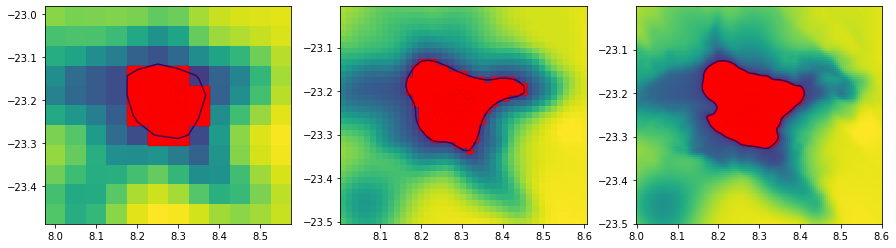

In [10]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3,1)
plt.pcolormesh(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)))#,levels=20)
cl_INALT=plt.contour(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)),levels=[1500])
plt.scatter(releasepoints_INALT['lon'],releasepoints_INALT['lat'],s=0.01,color='red')

plt.subplot(1, 3,2)
plt.pcolormesh(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
cl_ROMS=plt.contour(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
plt.scatter(releasepoints_ROMS['lon'],releasepoints_ROMS['lat'],s=0.01,color='red')
#ROMS_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.01,color='red')

plt.subplot(1, 3,3)
plt.pcolormesh(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
cl_ROMSchild=plt.contour(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
plt.scatter(releasepoints_ROMSchild['lon'],releasepoints_ROMSchild['lat'],s=0.01,color='red')
#ROMSchild_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.01,color='red');

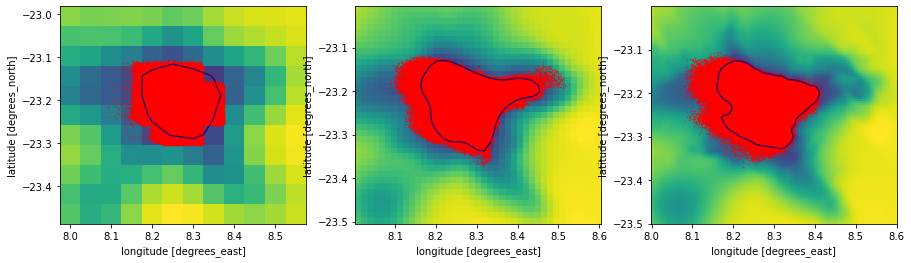

In [11]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3,1)
plt.pcolormesh(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)))#,levels=20)
cl_INALT=plt.contour(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)),levels=[1500])
particle_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.1,color='red')

plt.subplot(1, 3,2)
plt.pcolormesh(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
cl_ROMS=plt.contour(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
ROMS_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.1,color='red')

plt.subplot(1, 3,3)
plt.pcolormesh(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
cl_ROMSchild=plt.contour(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
ROMSchild_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.1,color='red');

In [12]:
import cmocean.cm as cmo
from matplotlib.colors import ListedColormap

cmap = plt.get_cmap('YlGnBu')
new_cmap = ListedColormap(cmap(np.linspace(0.2, 1, 100)))

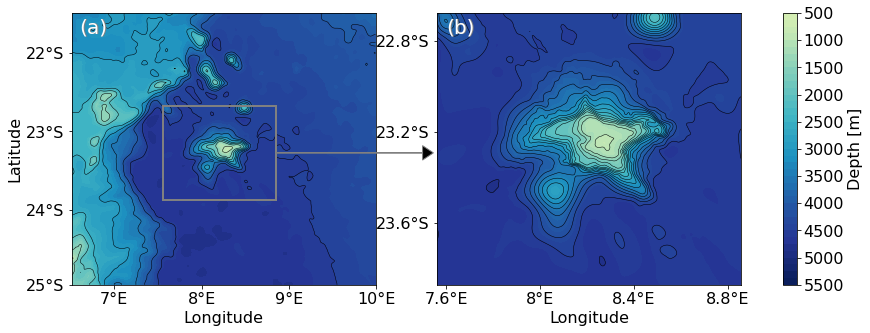

In [16]:
plt.rcParams.update({'font.size': 16})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

cf = ax1.contourf(SIGMA.h.lon_rho, SIGMA.h.lat_rho, SIGMA.h, cmap=new_cmap, levels=np.linspace(500, 5500, 41))
ax1.contour(SIGMA.h.lon_rho, SIGMA.h.lat_rho, SIGMA.h, colors='black', linewidths=0.5, levels=np.linspace(500, 5500, 11))
rect = plt.Rectangle((SIGMA_child.h.lon_rho.min(), SIGMA_child.h.lat_rho.min()), SIGMA_child.h.lon_rho.max() - SIGMA_child.h.lon_rho.min(),
                     SIGMA_child.h.lat_rho.max() - SIGMA_child.h.lat_rho.min(), edgecolor='gray', facecolor='none', linewidth=2, zorder=3)
ax1.add_patch(rect)
ax1.set_xlabel('Longitude')
ax1.set_xticks([7,8,9,10])
ax1.set_xticklabels(['7°E','8°E','9°E','10°E'])
ax1.set_ylabel('Latitude')
ax1.set_yticks([-24.96,-24,-23,-22])
ax1.set_yticklabels(['25°S','24°S','23°S','22°S'])

cf = ax2.contourf(SIGMA_child.h.lon_rho, SIGMA_child.h.lat_rho, SIGMA_child.h, cmap=new_cmap, levels=np.linspace(500, 5500, 41))
ax2.contour(SIGMA_child.h.lon_rho, SIGMA_child.h.lat_rho, SIGMA_child.h, colors='black', linewidths=0.5, levels=np.linspace(500, 5500, 21))
ax2.set_xticks([7.6,8,8.4,8.8])
ax2.set_xticklabels(['7.6°E','8°E','8.4°E','8.8°E'])
ax2.set_xlabel('Longitude')
ax2.set_yticks([-23.6,-23.2,-22.8])
ax2.set_yticklabels(['23.6°S','23.2°S','22.8°S'])

cbar = plt.colorbar(cf, ax=[ax1, ax2], orientation='vertical', ticks=np.arange(500, 6000, 500))
cbar.set_label('Depth [m]')
cbar.ax.invert_yaxis() 

fig.text(0.146, 0.839, '(a)', ha='center', va='center',color='gray',fontsize=20)
fig.text(0.145, 0.84, '(a)', ha='center', va='center',color='white',fontsize=20)
fig.text(0.486, 0.839, '(b)', ha='center', va='center',color='gray',fontsize=20)
fig.text(0.485, 0.84, '(b)', ha='center', va='center',color='white',fontsize=20)

#line1 = mlines.Line2D([0.209, 0.463], [0.623, 0.878], color='gray',linestyle='dotted')
#line2 = mlines.Line2D([0.209, 0.463], [0.36, 0.124], color='gray',linestyle='dotted')
#line3 = mlines.Line2D([0.315, 0.745], [0.623, 0.878], color='gray',linestyle='dotted')
#line4 = mlines.Line2D([0.315, 0.745], [0.36, 0.124], color='gray',linestyle='dotted')
#fig.add_artist(line1)
#fig.add_artist(line2)
#fig.add_artist(line3)
#fig.add_artist(line4)

arrow = patches.FancyArrow(0.315, 0.4915, 0.135, 0, head_width=0.04, head_length=0.01, fc='black', ec='gray')
fig.add_artist(arrow)

#plt.savefig('../../output_data/domain-ROMS.png', bbox_inches='tight')


In [14]:
hull_INALT=ConvexHull(releasepoints_INALT.to_numpy())
hull_ROMS=ConvexHull(releasepoints_ROMS.to_numpy())
hull_ROMSchild=ConvexHull(releasepoints_ROMSchild.to_numpy())

#INALT
x = np.array([8.175, 8.325, 8.325, 8.375, 8.375,
              8.325, 8.325, 8.225, 8.225, 8.175])
y = np.array([-23.12069, -23.12069, -23.1666665, -23.1666665, -23.2585715,
              -23.2585715, -23.3045005, -23.3045005, -23.2585715, -23.2585715])
#x = releasepoints_INALT.to_numpy()[hull_INALT.vertices, 0]
#y = releasepoints_INALT.to_numpy()[hull_INALT.vertices, 1]
#z = releasepoints_INALT.to_numpy()[hull_INALT.vertices, 2]
poly_INALT = Polygon([(i[0], i[1]) for i in zip(x,y)])
    
#ROMS
x  =np.array([8.1644115,8.1791175,8.1791175,8.193824,8.193824,
          8.2379415,8.2379415,8.267353,8.267353,8.3114705,8.3114705,
          8.355588,8.355588,8.370294,8.370294,8.4291175,8.4291175,
          8.4585295,8.4585295,8.4144115,8.4144115,8.385,8.385,8.370294,
          8.370294,8.355588,8.355588,8.340882,8.340882,8.3261765,8.3261765,
          8.3114705,8.3114705,8.282059,8.282059,8.223235,8.223235,8.2085295,
          8.2085295,8.193824,8.193824,8.1791175,8.1791175,8.1644115])
y = np.array([-23.1675815,-23.1675815,-23.14054,-23.14054,-23.127018,-23.127018,
          -23.14054,-23.14054,-23.154061,-23.154061,-23.1675815,-23.1675815,
          -23.1811,-23.1811,-23.1675815,-23.1675815,-23.1811,-23.1811,-23.2081335,
          -23.2081335,-23.221648,-23.221648,-23.235161,-23.235161,-23.2486725,-23.2486725,
          -23.275692,-23.275692,-23.316211,-23.316211,-23.343217,-23.343217,-23.329715,
          -23.329715,-23.316211,-23.316211,-23.302706,-23.302706,-23.2892,-23.2892,
          -23.235161,-23.235161,-23.2081335,-23.2081335])
#x = cl_ROMS.collections[0].get_paths()[0].vertices[:, 0] #releasepoints_ROMS.to_numpy()[hull_ROMS.vertices, 0]
#y = cl_ROMS.collections[0].get_paths()[0].vertices[:, 1] #releasepoints_ROMS.to_numpy()[hull_ROMS.vertices, 1]
#z = releasepoints_ROMS.to_numpy()[hull_ROMS.vertices, 2]
poly_ROMS = Polygon([(i[0], i[1]) for i in zip(x,y)])
    
#ROMSchild
x = cl_ROMSchild.collections[0].get_paths()[0].vertices[:, 0] #releasepoints_ROMSchild.to_numpy()[hull_ROMSchild.vertices, 0]
y = cl_ROMSchild.collections[0].get_paths()[0].vertices[:, 1] #releasepoints_ROMSchild.to_numpy()[hull_ROMSchild.vertices, 1]
#z = releasepoints_ROMSchild.to_numpy()[hull_ROMSchild.vertices, 2]
poly_ROMSchild = Polygon([(i[0], i[1]) for i in zip(x,y)])

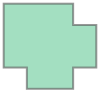

In [15]:
poly_INALT

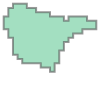

In [16]:
poly_ROMS

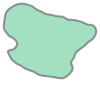

In [17]:
poly_ROMSchild

In [18]:
#Depths of levels in INALT and ROMS
INALT_levels = INALT_mask.gdept_0
INALT_levels = INALT_levels.isel(y=0,t=0,x=0)

ROMS_levels = SIGMA.hs.where(SIGMA.hs<7000)
ROMS_levels = ROMS_levels.isel(lat_rho=128).sel(lon_rho=slice(7.559,8.858,None))

ROMS_child_levels = SIGMA_child.hs.where(SIGMA_child.hs<7000)
ROMS_child_levels = ROMS_child_levels.isel(lat_rho=140).sel(lon_rho=slice(7.559,8.858,None))

#Bottom topography in both ROMS
topo_ROMS = SIGMA['h']
topo_ROMS = topo_ROMS.rename({'lat_rho': 'lat','lon_rho': 'lon'})
topo_ROMS_child = SIGMA_child['h']
topo_ROMS_child = topo_ROMS_child.rename({'lat_rho': 'lat','lon_rho': 'lon'})

topo_INALT_bar=topo_INALT.isel(lat=295).sel( #-23.24
               lon=slice(7.559,
                         8.858,None))
topo_INALT_bar=-(topo_INALT_bar-INALT_levels.max()) #reverse so that bar plot works

topo_ROMS_bar=topo_ROMS.isel(lat=128).sel( #-23.24
             lon=slice(7.559,
                         8.858,None))
topo_ROMS_bar=-(topo_ROMS_bar-ROMS_levels.max())#SIGMA.hs.where(SIGMA.hs<7000).max())

topo_ROMS_child_bar=topo_ROMS_child.isel(lat=140).sel( #-23.24
               lon=slice(7.559,
                         8.858,None))
topo_ROMS_child_bar=-(topo_ROMS_child_bar-ROMS_child_levels.max())#SIGMA_child.hs.where(SIGMA_child.hs<7000).max())

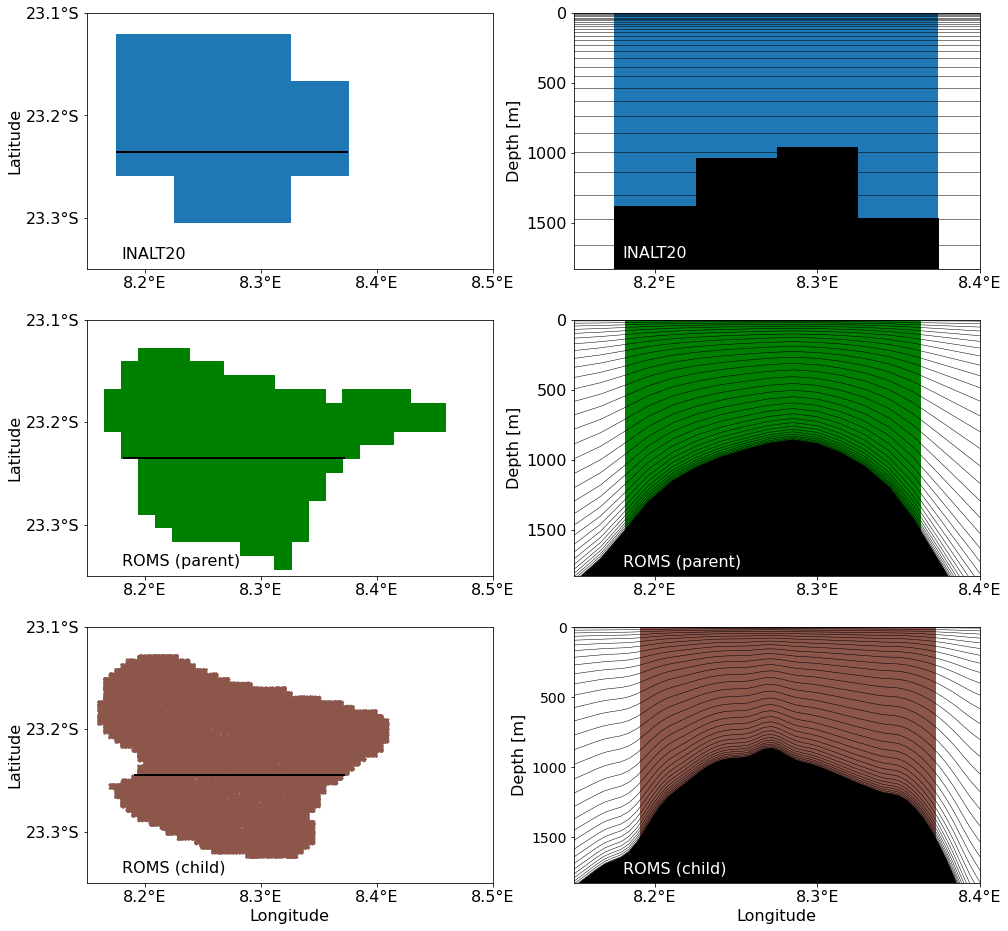

In [24]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(16, 16))

plt.subplot(3, 2,1)
x, y = poly_INALT.exterior.xy
plt.xlim(8.15, 8.5)
plt.ylim(-23.35, -23.1)
plt.fill(x, y, alpha=1, edgecolor='tab:blue', facecolor='tab:blue')
plt.xticks([8.2,8.3,8.4,8.5],['8.2°E','8.3°E','8.4°E','8.5°E'])
plt.ylabel('Latitude')
plt.yticks([-23.3,-23.2,-23.1],['23.3°S','23.2°S','23.1°S'])
plt.hlines(-23.235603,8.175,8.375,linewidth=2,color='black')
plt.text(8.18,-23.34,'INALT20',color='black')

plt.subplot(3, 2,3)
x, y = poly_ROMS.exterior.xy
plt.xlim(8.15, 8.5)
plt.ylim(-23.35, -23.1)
plt.fill(x, y, alpha=1, edgecolor='green', facecolor='green')
plt.xticks([8.2,8.3,8.4,8.5],['8.2°E','8.3°E','8.4°E','8.5°E'])
plt.ylabel('Latitude')
plt.yticks([-23.3,-23.2,-23.1],['23.3°S','23.2°S','23.1°S'])
plt.hlines(-23.235,8.1815,8.3725,linewidth=2,color='black')
plt.text(8.18,-23.34,'ROMS (parent)',color='black')

plt.subplot(3, 2,5)
plt.xlabel('Longitude')
plt.xlim(8.15, 8.5)
plt.ylim(-23.35, -23.1)
plt.scatter(releasepoints_ROMSchild['lon'],releasepoints_ROMSchild['lat'],s=0.8,color='tab:brown')
plt.xticks([8.2,8.3,8.4,8.5],['8.2°E','8.3°E','8.4°E','8.5°E'])
plt.ylabel('Latitude')
plt.yticks([-23.3,-23.2,-23.1],['23.3°S','23.2°S','23.1°S'])
plt.hlines(-23.245,8.191,8.3725,linewidth=2,color='black')
plt.text(8.18,-23.34,'ROMS (child)',color='black')

plt.subplot(3,2,2)
plt.fill_between(np.linspace(8.175,8.374,5),INALT_levels.max()-1500,INALT_levels.max(),color='tab:blue')
plt.bar(np.linspace(7.6,8.85,26),topo_INALT_bar,width=0.05,label='INALT',color='black')
plt.yticks(np.linspace(INALT_levels.max()-4000,INALT_levels.max(),9),[int(i) for i in np.linspace(4000,0,9)])
plt.xticks([8.2,8.3,8.4],['8.2°E','8.3°E','8.4°E'])
plt.ylabel('Depth [m]')
plt.xlim([8.15,8.4])
plt.ylim([4050,INALT_levels.max()])
plt.text(8.18,4130,'INALT20',color='white',zorder=10)
for i in INALT_levels:
    plt.plot(np.linspace(7.6,8.85,2),[-(i-INALT_levels.max()),-(i-INALT_levels.max())],color='black',linewidth='0.5')


plt.subplot(3,2,4)
plt.fill_between(np.linspace(8.1815,8.363,5),ROMS_levels.max()-1500,ROMS_levels.max(),color='green')
plt.fill_between(np.linspace(7.559,8.848,88), 0, topo_ROMS_bar,color='black',label='ROMS (parent)')
plt.xticks([8.2,8.3,8.4],['8.2°E','8.3°E','8.4°E'])
plt.ylabel('Depth [m]')
plt.yticks(np.linspace(ROMS_levels.max()-4000,ROMS_levels.max(),9),[int(i) for i in np.linspace(4000,0,9)])
plt.ylim([4050-(INALT_levels.max()-ROMS_levels.max()),ROMS_levels.max()])
plt.xlim([8.15,8.4])
plt.text(8.18,2880,'ROMS (parent)',color='white',zorder=10)
for i in [int(j) for j in np.linspace(0,len(ROMS_levels.slev)-1,len(ROMS_levels.slev))]:
    plt.plot(np.linspace(7.559,8.848,88),-(ROMS_levels.isel(slev=i)-ROMS_levels.max()),color='black',linewidth='0.5')


plt.subplot(3,2,6)
plt.fill_between(np.linspace(8.191,8.3725,5),ROMS_child_levels.max()-1500,ROMS_child_levels.max(),color='tab:brown')
plt.fill_between(np.linspace(7.559,8.848,265), 0, topo_ROMS_child_bar,color='black',label='ROMS (child)')
plt.xticks([8.2,8.3,8.4],['8.2°E','8.3°E','8.4°E'])
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.yticks(np.linspace(ROMS_child_levels.max()-4000,ROMS_child_levels.max(),9),[int(i) for i in np.linspace(4000,0,9)],fontsize=14)
plt.ylim([4050-(INALT_levels.max()-ROMS_child_levels.max()),ROMS_child_levels.max()])
plt.xlim([8.15,8.4])
plt.text(8.18,2880,'ROMS (child)',color='white',zorder=10)
for i in [int(j) for j in np.linspace(0,len(ROMS_child_levels.slev)-1,len(ROMS_child_levels.slev))]:
    plt.plot(np.linspace(7.559,8.848,265),-(ROMS_child_levels.isel(slev=i)-ROMS_child_levels.max()),color='black',linewidth='0.5',zorder=12)


plt.savefig('../../output_data/releasecolumns.png', bbox_inches='tight');

In [21]:
#particle_ds['depthdiff'] = particle_ds.topography-particle_ds.z
ROMS_ds['depthdiff'] = ROMS_ds.topography-ROMS_ds.z
ROMSchild_ds['depthdiff'] = ROMSchild_ds.topography-ROMSchild_ds.z

In [22]:
%%time

df_INALT1 = particle_ds.where(particle_ds.isel(obs=0).z<=MLD_INALT_5d,drop=True).to_dataframe()
df_INALT2 = particle_ds.where((particle_ds.isel(obs=0).z>MLD_INALT_5d) & (particle_ds.isel(obs=0).depthdiff > 100),drop=True).to_dataframe()
df_INALT3 = particle_ds.where((particle_ds.isel(obs=0).depthdiff < 100), drop=True).to_dataframe()

df_ROMS1 = ROMS_ds.where(ROMS_ds.isel(obs=0).z<=MLD_ROMS_5d,drop=True).to_dataframe()
df_ROMS2 = ROMS_ds.where((ROMS_ds.isel(obs=0).z>MLD_ROMS_5d) & (ROMS_ds.isel(obs=0).depthdiff > 100),drop=True).to_dataframe()
df_ROMS3 = ROMS_ds.where((ROMS_ds.isel(obs=0).depthdiff < 100),drop=True).to_dataframe()

df_ROMSchild1 = ROMSchild_ds.where(ROMSchild_ds.isel(obs=0).z<=MLD_ROMSchild_5d,drop=True).to_dataframe()
df_ROMSchild2 = ROMSchild_ds.where((ROMSchild_ds.isel(obs=0).z>MLD_ROMSchild_5d) & (ROMSchild_ds.isel(obs=0).depthdiff > 100),drop=True).to_dataframe()
df_ROMSchild3 = ROMSchild_ds.where((ROMSchild_ds.isel(obs=0).depthdiff < 100),drop=True).to_dataframe()

CPU times: user 26.9 s, sys: 548 ms, total: 27.4 s
Wall time: 27.8 s


In [ ]:
%%time

df_INALT1["is_in_level"] = df_INALT1.apply(lambda row: poly_INALT.contains(
    Point(row.loc["lon"], row.loc["lat"])), axis=1)
df_INALT2["is_in_level"] = df_INALT2.apply(lambda row: poly_INALT.contains(
    Point(row.loc["lon"], row.loc["lat"])), axis=1)
df_INALT3["is_in_level"] = df_INALT3.apply(lambda row: poly_INALT.contains(
    Point(row.loc["lon"], row.loc["lat"])), axis=1)

df_ROMS1["is_in_level"] = df_ROMS1.apply(lambda row: poly_ROMS.contains(
     Point(row.loc["lon"], row.loc["lat"])), axis=1)
df_ROMS2["is_in_level"] = df_ROMS2.apply(lambda row: poly_ROMS.contains(
     Point(row.loc["lon"], row.loc["lat"])), axis=1)
df_ROMS3["is_in_level"] = df_ROMS3.apply(lambda row: poly_ROMS.contains(
     Point(row.loc["lon"], row.loc["lat"])), axis=1)
df_ROMSchild1["is_in_level"] = df_ROMSchild1.apply(lambda row: poly_ROMSchild.contains(
     Point(row.loc["lon"], row.loc["lat"])), axis=1)
df_ROMSchild2["is_in_level"] = df_ROMSchild2.apply(lambda row: poly_ROMSchild.contains(
     Point(row.loc["lon"], row.loc["lat"])), axis=1)
df_ROMSchild3["is_in_level"] = df_ROMSchild3.apply(lambda row: poly_ROMSchild.contains(
     Point(row.loc["lon"], row.loc["lat"])), axis=1)

In [ ]:
INALT_1bool_xr, ROMS_1bool_xr, ROMSchild_1bool_xr = df_INALT1.to_xarray(), df_ROMS1.to_xarray(), df_ROMSchild1.to_xarray()
INALT_2bool_xr, ROMS_2bool_xr, ROMSchild_2bool_xr = df_INALT2.to_xarray(), df_ROMS2.to_xarray(), df_ROMSchild2.to_xarray()
INALT_3bool_xr, ROMS_3bool_xr, ROMSchild_3bool_xr = df_INALT3.to_xarray(), df_ROMS3.to_xarray(), df_ROMSchild3.to_xarray()

In [ ]:
atmount_INALT1, atmount_ROMS1, atmount_ROMSchild1 = [], [], []
atmount_INALT2, atmount_ROMS2, atmount_ROMSchild2 = [], [], []
atmount_INALT3, atmount_ROMS3, atmount_ROMSchild3 = [], [], []

for i in np.arange(len(INALT_1bool_xr.obs)):
    cut1 = INALT_1bool_xr.where(INALT_1bool_xr.sel(obs=i).is_in_level == True, drop = True)
    atmount_INALT1.append(len(cut1.traj)/len(INALT_1bool_xr.isel(obs=0).traj))
for i in np.arange(len(INALT_2bool_xr.obs)):
    cut2 = INALT_2bool_xr.where(INALT_2bool_xr.sel(obs=i).is_in_level == True, drop = True)
    atmount_INALT2.append(len(cut2.traj)/len(INALT_2bool_xr.isel(obs=0).traj))
for i in np.arange(len(INALT_3bool_xr.obs)):
    cut3 = INALT_3bool_xr.where((INALT_3bool_xr.sel(obs=i).is_in_level == True) & (
        INALT_3bool_xr.sel(obs=i).depthdiff < 100), drop = True)
    atmount_INALT3.append(len(cut3.traj)/len(INALT_3bool_xr.isel(obs=0).traj))
    
for i in np.arange(len(ROMS_1bool_xr.obs)):
    cut4 = ROMS_1bool_xr.where(ROMS_1bool_xr.sel(obs=i).is_in_level == True, drop = True)
    atmount_ROMS1.append(len(cut4.traj)/len(ROMS_1bool_xr.isel(obs=0).traj))
for i in np.arange(len(ROMS_2bool_xr.obs)):
    cut5 = ROMS_2bool_xr.where(ROMS_2bool_xr.sel(obs=i).is_in_level == True, drop = True)
    atmount_ROMS2.append(len(cut5.traj)/len(ROMS_2bool_xr.isel(obs=0).traj))
for i in np.arange(len(ROMS_3bool_xr.obs)):
    cut6 = ROMS_3bool_xr.where((ROMS_3bool_xr.sel(obs=i).is_in_level == True),# & (
        #ROMS_3bool_xr.sel(obs=i).depthdiff < 100),
        drop = True)
    atmount_ROMS3.append(len(cut6.traj)/len(ROMS_3bool_xr.isel(obs=0).traj))
    
for i in np.arange(len(ROMSchild_1bool_xr.obs)):
    cut7 = ROMSchild_1bool_xr.where(ROMSchild_1bool_xr.sel(obs=i).is_in_level == True, drop = True)
    atmount_ROMSchild1.append(len(cut7.traj)/len(ROMSchild_1bool_xr.isel(obs=0).traj))
for i in np.arange(len(ROMSchild_2bool_xr.obs)):
    cut8 = ROMSchild_2bool_xr.where(ROMSchild_2bool_xr.sel(obs=i).is_in_level == True, drop = True)
    atmount_ROMSchild2.append(len(cut8.traj)/len(ROMSchild_2bool_xr.isel(obs=0).traj))
for i in np.arange(len(ROMSchild_3bool_xr.obs)):
    cut9 = ROMSchild_3bool_xr.where((ROMSchild_3bool_xr.sel(obs=i).is_in_level == True) & (
        ROMSchild_3bool_xr.sel(obs=i).depthdiff < 100), drop = True)
    atmount_ROMSchild3.append(len(cut9.traj)/len(ROMSchild_3bool_xr.isel(obs=0).traj))

In [ ]:
dict = {'INALT-ML': atmount_INALT1,'INALT-rest': atmount_INALT2,'INALT-bottom-100': atmount_INALT3,
        'ROMS-ML': atmount_ROMS1,'ROMS-rest': atmount_ROMS2,'ROMS-bottom-100': atmount_ROMS3,
        'ROMSchild-ML': atmount_ROMSchild1,'ROMSchild-rest': atmount_ROMSchild2,'ROMSchild-bottom-100': atmount_ROMSchild3}

In [ ]:
pd.DataFrame(dict).to_csv(f'/gxfs_work/geomar/smomw523/master-thesis/output_data/retention/10mins/{start_year:04d}{start_month:02d}{start_day:02d}.csv')

In [ ]:
plt.plot(atmount_INALT1,label='INALT')
plt.plot(atmount_ROMS1, color = 'tab:brown',label='ROMS')
plt.plot(atmount_ROMSchild1, color = 'green',label='ROMS child')

threshold = 1/np.e

lines = plt.gca().get_lines()
x_data = lines[0].get_xdata()
y_data1 = lines[0].get_ydata()
y_data2 = lines[1].get_ydata()
y_data3 = lines[2].get_ydata()

intersec_INALT = None
intersec_ROMS = None
intersec_ROMSchild = None

for i in range(len(x_data)):
    if y_data1[i] < threshold and intersec_INALT is None:
        intersec_INALT = x_data[i]
    if y_data2[i] < threshold and intersec_ROMS is None:
        intersec_ROMS = x_data[i]
    if y_data3[i] < threshold and intersec_ROMSchild is None:
        intersec_ROMSchild = x_data[i]

#Intersec times
print("Level 1:")
if intersec_INALT is not None:
    print(f"INALT is below the 1/e threshold at obs = {intersec_INALT}.")
else:
    print(f"INALT does not pass the 1/e threshold.")

if intersec_ROMS is not None:
    print(f"ROMS (parent) is below the 1/e threshold at obs = {intersec_ROMS}.")
else:
    print(f"ROMS (parent) does not pass the 1/e threshold.")

if intersec_ROMSchild is not None:
    print(f"ROMS (child) is below the 1/e threshold at obs = {intersec_ROMSchild}.")
else:
    print(f"ROMS (child) does not pass the 1/e threshold.")

plt.axhline(y=threshold, color='gray', linestyle='-.')
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.xticks([0,7,14,21,28,35,42],fontsize=12)
plt.yticks([0,0.2,.4,.6,.8,1],['0%','20%','40%','60%','80%','100%'],fontsize=12)
plt.xlim([0,42])
plt.ylim([0,1])
plt.ylabel('Particles in seamount column',fontsize=12)
plt.xlabel('Days since dispersal',fontsize=12)

plt.legend(fontsize=12)
plt.show()

In [ ]:
plt.plot(atmount_INALT2,label='INALT')
plt.plot(atmount_ROMS2, color = 'tab:brown',label='ROMS')
plt.plot(atmount_ROMSchild2, color = 'green',label='ROMS child')

threshold = 1/np.e

lines = plt.gca().get_lines()
x_data = lines[0].get_xdata()
y_data1 = lines[0].get_ydata()
y_data2 = lines[1].get_ydata()
y_data3 = lines[2].get_ydata()

intersec_INALT = None
intersec_ROMS = None
intersec_ROMSchild = None

for i in range(len(x_data)):
    if y_data1[i] < threshold and intersec_INALT is None:
        intersec_INALT = x_data[i]
    if y_data2[i] < threshold and intersec_ROMS is None:
        intersec_ROMS = x_data[i]
    if y_data3[i] < threshold and intersec_ROMSchild is None:
        intersec_ROMSchild = x_data[i]

#Intersec times
print("Level 2:")
if intersec_INALT is not None:
    print(f"INALT is below the 1/e threshold at obs = {intersec_INALT}.")
else:
    print(f"INALT does not pass the 1/e threshold.")

if intersec_ROMS is not None:
    print(f"ROMS (parent) is below the 1/e threshold at obs = {intersec_ROMS}.")
else:
    print(f"ROMS (parent) does not pass the 1/e threshold.")

if intersec_ROMSchild is not None:
    print(f"ROMS (child) is below the 1/e threshold at obs = {intersec_ROMSchild}.")
else:
    print(f"ROMS (child) does not pass the 1/e threshold.")

plt.axhline(y=threshold, color='gray', linestyle='-.')
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.xticks([0,7,14,21,28,35,42],fontsize=12)
plt.yticks([0,0.2,.4,.6,.8,1],['0%','20%','40%','60%','80%','100%'],fontsize=12)
plt.xlim([0,42])
plt.ylim([0,1])
plt.ylabel('Particles in seamount column',fontsize=12)
plt.xlabel('Days since dispersal',fontsize=12)

plt.legend(fontsize=12)
plt.show()

In [ ]:
plt.plot(atmount_INALT3,label='INALT')
plt.plot(atmount_ROMS3, color = 'tab:brown',label='ROMS')
plt.plot(atmount_ROMSchild3, color = 'green',label='ROMS child')

threshold = 1/np.e

lines = plt.gca().get_lines()
x_data = lines[0].get_xdata()
y_data1 = lines[0].get_ydata()
y_data2 = lines[1].get_ydata()
y_data3 = lines[2].get_ydata()

intersec_INALT = None
intersec_ROMS = None
intersec_ROMSchild = None

for i in range(len(x_data)):
    if y_data1[i] < threshold and intersec_INALT is None:
        intersec_INALT = x_data[i]
    if y_data2[i] < threshold and intersec_ROMS is None:
        intersec_ROMS = x_data[i]
    if y_data3[i] < threshold and intersec_ROMSchild is None:
        intersec_ROMSchild = x_data[i]

#Intersec times
print("Level 3:")
if intersec_INALT is not None:
    print(f"INALT is below the 1/e threshold at obs = {intersec_INALT}.")
else:
    print(f"INALT does not pass the 1/e threshold.")

if intersec_ROMS is not None:
    print(f"ROMS (parent) is below the 1/e threshold at obs = {intersec_ROMS}.")
else:
    print(f"ROMS (parent) does not pass the 1/e threshold.")

if intersec_ROMSchild is not None:
    print(f"ROMS (child) is below the 1/e threshold at obs = {intersec_ROMSchild}.")
else:
    print(f"ROMS (child) does not pass the 1/e threshold.")

plt.axhline(y=threshold, color='gray', linestyle='-.')
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.xticks([0,7,14,21,28,35,42],fontsize=12)
plt.yticks([0,0.2,.4,.6,.8,1],['0%','20%','40%','60%','80%','100%'],fontsize=12)
plt.xlim([0,42])
plt.ylim([0,1])
plt.ylabel('Particles in seamount column',fontsize=12)
plt.xlabel('Days since dispersal',fontsize=12)

plt.legend(fontsize=12)
plt.show()